# Simulasi Antrean Kasir Minimarket Indonesia (DES dengan SimPy)

## Ringkasan
Notebook ini membangun simulasi *Discrete Event Simulation (DES)* untuk antrean kasir minimarket dengan dua skema:
1) **Single Queue**: satu antrean untuk semua kasir (FCFS)  
2) **Multi-Queue**: tiap kasir punya antrean sendiri (FCFS), pelanggan memilih antrean terpendek  

## Tujuan
- Mengukur performa antrean: waktu tunggu, waktu di sistem, panjang antrean, dan utilisasi kasir.
- Membandingkan kebijakan antrean (single vs multi) dan melakukan eksperimen "what-if" (jumlah kasir).
- Menentukan keputusan operasional berbasis SLA.

## Mengapa Discrete Event Simulation?
Antrean berubah karena *event* (kedatangan, mulai dilayani, selesai dilayani), sehingga cocok dimodelkan sebagai DES.

## Asumsi awal yang rasional (minimarket Indonesia)
Asumsi ini baseline ketika belum ada data observasi.

### A) Pola kedatangan (arrival rate)
- Kedatangan pelanggan diasumsikan Poisson (interarrival time eksponensial).
- Ada jam sibuk (peak):
  - **Normal**: 0.6 pelanggan/menit (≈ 36/jam)
  - **Sibuk**: 1.2 pelanggan/menit (≈ 72/jam)
- Durasi simulasi 8 jam (480 menit), satu peak: menit 120–240.

### B) Waktu layanan (service time)
Waktu layanan miring (ada ekor panjang), gunakan **lognormal**:
- 70% pelanggan “belanja sedikit”: median 50 detik  
- 30% pelanggan “belanja banyak”: median 110 detik  
- 3% transaksi mengalami gangguan kecil (barcode sulit/pembayaran lama) tambah 40–90 detik.

### C) Pengaturan simulasi
- Durasi: 480 menit
- Warm-up: 30 menit pertama dibuang dari metrik
- Replikasi: 30 run per skenario

## Metrik yang diukur
- Mean waiting time (menit)
- Mean time in system (menit)
- P50/P90/P95 waiting time & system time (melihat ekor panjang)
- Avg & max queue length (avg = time-weighted)
- Utilization kasir

In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Dict, Tuple, Callable

## 1) Parameter model & distribusi acak

Semua parameter dimasukkan ke satu struktur agar mudah dikalibrasi.
Kita definisikan:
- fungsi λ(t) untuk jam normal/sibuk,
- fungsi sampling service time (campuran lognormal + gangguan).

In [2]:
@dataclass
class ModelParams:
    sim_minutes: int = 480
    warmup_minutes: int = 30

    # arrival rate (customers/minute)
    lambda_normal: float = 0.6
    lambda_peak: float = 1.2
    peak_start: int = 120
    peak_end: int = 240

    # service time mixture
    p_small: float = 0.70
    median_small_sec: float = 50.0
    median_large_sec: float = 110.0
    sigma_small: float = 0.45
    sigma_large: float = 0.55

    # disruption
    p_disruption: float = 0.03
    disruption_low_sec: float = 40.0
    disruption_high_sec: float = 90.0


def arrival_rate(t_min: float, p: ModelParams) -> float:
    """Piecewise λ(t): customers per minute."""
    return p.lambda_peak if (p.peak_start <= t_min < p.peak_end) else p.lambda_normal


def lognormal_from_median(median_sec: float, sigma: float, rng: np.random.Generator) -> float:
    """
    If X ~ LogNormal(mu, sigma), median = exp(mu) => mu = ln(median)
    """
    mu = np.log(median_sec)
    return float(rng.lognormal(mean=mu, sigma=sigma))


def sample_service_time_min(p: ModelParams, rng: np.random.Generator) -> float:
    """Return service time in minutes."""
    if rng.random() < p.p_small:
        sec = lognormal_from_median(p.median_small_sec, p.sigma_small, rng)
    else:
        sec = lognormal_from_median(p.median_large_sec, p.sigma_large, rng)

    if rng.random() < p.p_disruption:
        sec += rng.uniform(p.disruption_low_sec, p.disruption_high_sec)

    return sec / 60.0


params = ModelParams()
params

ModelParams(sim_minutes=480, warmup_minutes=30, lambda_normal=0.6, lambda_peak=1.2, peak_start=120, peak_end=240, p_small=0.7, median_small_sec=50.0, median_large_sec=110.0, sigma_small=0.45, sigma_large=0.55, p_disruption=0.03, disruption_low_sec=40.0, disruption_high_sec=90.0)

## 2) Monitor panjang antrean (time-weighted average)

Rata-rata panjang antrean sebaiknya dihitung time-weighted:
- setiap terjadi event, kita akumulasikan area = (queue_length × delta_time)
- avg_queue = area / durasi pengamatan (setelah warm-up)

In [3]:
class QueueMonitor:
    def __init__(self, warmup: int):
        self.warmup = warmup
        self.started = False
        self.last_t = 0.0
        self.last_q = 0
        self.area = 0.0
        self.max_q = 0

    def update(self, t: float, q_len: int):
        if t < self.warmup:
            self.last_t = t
            self.last_q = q_len
            return

        if not self.started:
            self.started = True
            self.last_t = t
            self.last_q = q_len
            self.max_q = q_len
            return

        dt = t - self.last_t
        if dt > 0:
            self.area += self.last_q * dt

        self.last_t = t
        self.last_q = q_len
        self.max_q = max(self.max_q, q_len)

    def average(self, t_end: float) -> float:
        if not self.started:
            return 0.0
        duration = t_end - self.warmup
        return self.area / duration if duration > 0 else 0.0

## 3) Simulator detail (mengembalikan daftar waiting time)

Agar bisa menghitung P90/P95, kita butuh **waiting time per pelanggan**.
Kita buat simulator detail untuk:
- Single Queue
- Multi-Queue (shortest line)

Keduanya mengembalikan:
- array waits, systems (setelah warm-up)
- avg/max queue length
- utilization

In [4]:
@dataclass
class RunDetail:
    model: str
    cashiers: int
    waits: np.ndarray
    systems: np.ndarray
    avg_queue_len: float
    max_queue_len: int
    utilization: float

In [5]:
def simulate_single_queue_detail(cashiers_n: int, p: ModelParams, seed: int) -> RunDetail:
    rng = np.random.default_rng(seed)
    env = simpy.Environment()
    cashiers = simpy.Resource(env, capacity=cashiers_n)

    waits: List[float] = []
    systems: List[float] = []
    monitor = QueueMonitor(p.warmup_minutes)
    busy_time = 0.0

    def customer(cid: int):
        nonlocal busy_time
        t_arr = env.now
        monitor.update(env.now, len(cashiers.queue))

        with cashiers.request() as req:
            yield req
            t_start = env.now
            monitor.update(env.now, len(cashiers.queue))

            st = sample_service_time_min(p, rng)

            if t_arr >= p.warmup_minutes:
                waits.append(t_start - t_arr)
                if t_start >= p.warmup_minutes:
                    busy_time += st

            yield env.timeout(st)

            t_dep = env.now
            if t_arr >= p.warmup_minutes:
                systems.append(t_dep - t_arr)

            monitor.update(env.now, len(cashiers.queue))

    def arrivals():
        cid = 0
        while env.now < p.sim_minutes:
            lam = arrival_rate(env.now, p)
            inter = rng.exponential(1.0 / lam) if lam > 0 else 1e9
            yield env.timeout(inter)
            cid += 1
            env.process(customer(cid))
            monitor.update(env.now, len(cashiers.queue))

    env.process(arrivals())
    env.run(until=p.sim_minutes)

    obs = max(p.sim_minutes - p.warmup_minutes, 1e-9)
    util = busy_time / (cashiers_n * obs)

    return RunDetail(
        model="single_queue",
        cashiers=cashiers_n,
        waits=np.array(waits, dtype=float),
        systems=np.array(systems, dtype=float),
        avg_queue_len=float(monitor.average(p.sim_minutes)),
        max_queue_len=int(monitor.max_q),
        utilization=float(util),
    )

In [6]:
def simulate_multi_queue_detail(cashiers_n: int, p: ModelParams, seed: int) -> RunDetail:
    rng = np.random.default_rng(seed)
    env = simpy.Environment()
    cashiers = [simpy.Resource(env, capacity=1) for _ in range(cashiers_n)]

    waits: List[float] = []
    systems: List[float] = []
    monitor = QueueMonitor(p.warmup_minutes)
    busy_time = 0.0

    def approx_line_length(r: simpy.Resource) -> int:
        # waiting + (1 if busy)
        return len(r.queue) + (1 if r.count > 0 else 0)

    def total_waiting() -> int:
        return sum(len(r.queue) for r in cashiers)

    def customer(cid: int):
        nonlocal busy_time
        t_arr = env.now
        monitor.update(env.now, total_waiting())

        lengths = [approx_line_length(r) for r in cashiers]
        min_len = min(lengths)
        candidates = [i for i, L in enumerate(lengths) if L == min_len]
        idx = int(rng.choice(candidates))
        chosen = cashiers[idx]

        with chosen.request() as req:
            yield req
            t_start = env.now
            monitor.update(env.now, total_waiting())

            st = sample_service_time_min(p, rng)
            if t_arr >= p.warmup_minutes:
                waits.append(t_start - t_arr)
            if t_start >= p.warmup_minutes:
                busy_time += st

            yield env.timeout(st)

            t_dep = env.now
            if t_arr >= p.warmup_minutes:
                systems.append(t_dep - t_arr)

            monitor.update(env.now, total_waiting())

    def arrivals():
        cid = 0
        while env.now < p.sim_minutes:
            lam = arrival_rate(env.now, p)
            inter = rng.exponential(1.0 / lam) if lam > 0 else 1e9
            yield env.timeout(inter)
            cid += 1
            env.process(customer(cid))
            monitor.update(env.now, total_waiting())

    env.process(arrivals())
    env.run(until=p.sim_minutes)

    obs = max(p.sim_minutes - p.warmup_minutes, 1e-9)
    util = busy_time / (cashiers_n * obs)

    return RunDetail(
        model="multi_queue_shortest",
        cashiers=cashiers_n,
        waits=np.array(waits, dtype=float),
        systems=np.array(systems, dtype=float),
        avg_queue_len=float(monitor.average(p.sim_minutes)),
        max_queue_len=int(monitor.max_q),
        utilization=float(util),
    )

## 4) Replikasi & ringkasan metrik (mean + P50/P90/P95)

Kita jalankan beberapa replikasi karena DES stokastik.  
Untuk metrik distribusi (P90/P95), kita gabungkan waiting time dari semua replikasi.

In [7]:
def run_replications_detail(sim_func: Callable, cashiers_n: int, p, n_rep: int, seed0: int) -> List[RunDetail]:
    out = []
    for i in range(n_rep):
        out.append(sim_func(cashiers_n, p, seed=seed0 + i))
    return out

def percentiles(x: np.ndarray, ps=(50, 90, 95)) -> Dict[str, float]:
    if x.size == 0:
        return {f"p{p}": np.nan for p in ps}
    vals = np.percentile(x, ps)
    return {f"p{p}": float(v) for p, v in zip(ps, vals)}

def summarize_detail(runs: List[RunDetail]) -> Dict[str, float]:
    waits = np.concatenate([r.waits for r in runs]) if runs else np.array([])
    systems = np.concatenate([r.systems for r in runs]) if runs else np.array([])

    avg_queue = float(np.mean([r.avg_queue_len for r in runs])) if runs else np.nan
    max_queue = float(np.mean([r.max_queue_len for r in runs])) if runs else np.nan
    util = float(np.mean([r.utilization for r in runs])) if runs else np.nan

    d = {
        "mean_wait": float(np.mean(waits)) if waits.size else np.nan,
        "mean_system": float(np.mean(systems)) if systems.size else np.nan,
        "avg_queue_len": avg_queue,
        "max_queue_len": max_queue,
        "utilization": util,
        "n_customers": int(waits.size),
    }
    d.update({f"wait_{k}": v for k, v in percentiles(waits).items()})
    d.update({f"system_{k}": v for k, v in percentiles(systems).items()})
    return d

In [8]:
NREP = 30
rows = []

for c in [1, 2, 3, 4]:
    runs_s = run_replications_detail(simulate_single_queue_detail, c, params, NREP, seed0=10000 + 100*c)
    runs_m = run_replications_detail(simulate_multi_queue_detail, c, params, NREP, seed0=20000 + 100*c)

    s_sum = summarize_detail(runs_s); s_sum.update({"model": "single_queue", "cashiers": c})
    m_sum = summarize_detail(runs_m); m_sum.update({"model": "multi_queue_shortest", "cashiers": c})

    rows += [s_sum, m_sum]

baseline_df = pd.DataFrame(rows).sort_values(["cashiers","model"])
baseline_df[["model","cashiers","mean_wait","wait_p90","wait_p95","utilization","avg_queue_len","n_customers"]]

,model,cashiers,mean_wait,wait_p90,wait_p95,utilization,avg_queue_len,n_customers
1,multi_queue_shortest,1,37.082982,71.485021,79.337356,0.951598,27.503377,9759
0,single_queue,1,39.036879,77.538485,88.284036,0.953845,29.283236,9780
3,multi_queue_shortest,2,0.882763,2.881524,4.662658,0.503353,0.567468,10325
2,single_queue,2,0.736862,2.313778,3.724512,0.501378,0.450041,10236
5,multi_queue_shortest,3,0.155623,0.360274,1.150148,0.339821,0.091407,10279
4,single_queue,3,0.078639,0.178236,0.574105,0.332351,0.033190,10234
7,multi_queue_shortest,4,0.032243,0.000000,0.000000,0.246544,0.018876,10094
6,single_queue,4,0.015585,0.000000,0.000000,0.253000,0.005012,10364


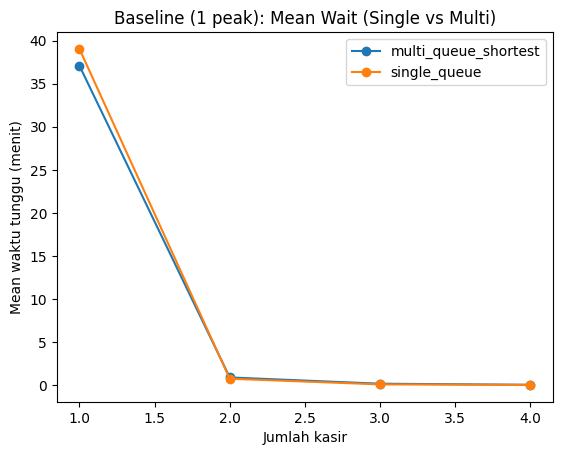

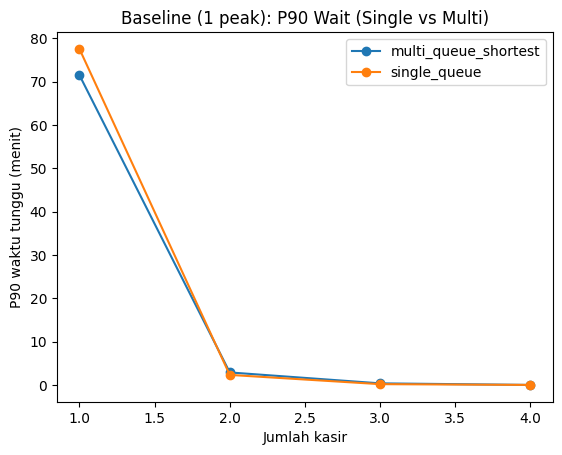

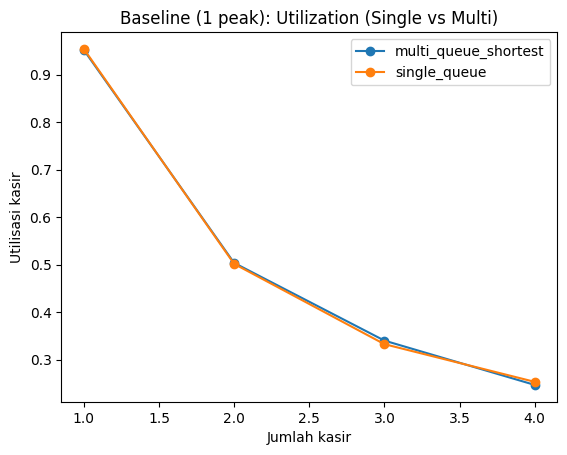

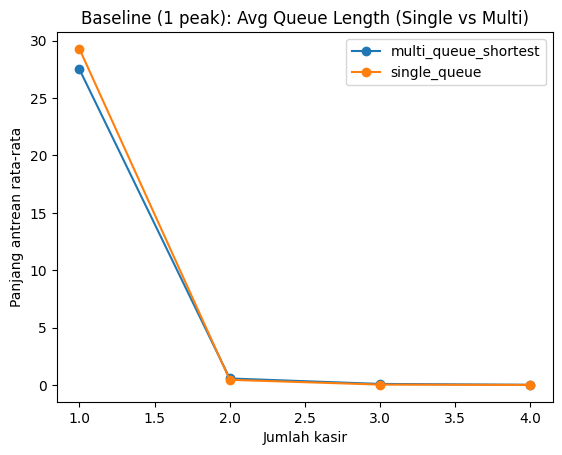

In [9]:
def plot_compare(df: pd.DataFrame, metric: str, ylabel: str, title: str):
    plt.figure()
    for model_name in df["model"].unique():
        s = df[df["model"] == model_name].sort_values("cashiers")
        plt.plot(s["cashiers"], s[metric], marker="o", label=model_name)
    plt.xlabel("Jumlah kasir")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

plot_compare(baseline_df, "mean_wait", "Mean waktu tunggu (menit)", "Baseline (1 peak): Mean Wait (Single vs Multi)")
plot_compare(baseline_df, "wait_p90", "P90 waktu tunggu (menit)", "Baseline (1 peak): P90 Wait (Single vs Multi)")
plot_compare(baseline_df, "utilization", "Utilisasi kasir", "Baseline (1 peak): Utilization (Single vs Multi)")
plot_compare(baseline_df, "avg_queue_len", "Panjang antrean rata-rata", "Baseline (1 peak): Avg Queue Length (Single vs Multi)")

## 5) SLA: mencari jumlah kasir minimum

Contoh SLA realistis:
- mean waiting time ≤ 3 menit
- P90 waiting time ≤ 5 menit

Kita cari jumlah kasir minimum untuk memenuhi SLA (mean, P90, dan keduanya).

In [10]:
def find_min_cashiers_for_sla(
    sim_func: Callable,
    p,
    cashiers_range=range(1, 8),
    n_rep: int = 30,
    seed0: int = 30000,
    sla_mean_wait: float = 3.0,
    sla_p90_wait: float = 5.0
) -> Tuple[pd.DataFrame, Dict[str, int]]:
    rows = []
    pass_mean = None
    pass_p90 = None
    pass_both = None

    for c in cashiers_range:
        runs = run_replications_detail(sim_func, c, p, n_rep=n_rep, seed0=seed0 + 100*c)
        s = summarize_detail(runs)
        s["cashiers"] = c
        rows.append(s)

        ok_mean = (s["mean_wait"] <= sla_mean_wait)
        ok_p90 = (s["wait_p90"] <= sla_p90_wait)
        ok_both = ok_mean and ok_p90

        if pass_mean is None and ok_mean:
            pass_mean = c
        if pass_p90 is None and ok_p90:
            pass_p90 = c
        if pass_both is None and ok_both:
            pass_both = c

    df = pd.DataFrame(rows).sort_values("cashiers")
    decision = {
        "min_cashiers_mean_wait": pass_mean if pass_mean is not None else -1,
        "min_cashiers_p90_wait": pass_p90 if pass_p90 is not None else -1,
        "min_cashiers_both": pass_both if pass_both is not None else -1,
    }
    return df, decision

In [11]:
SLA_MEAN = 3.0
SLA_P90  = 5.0

sla_single_df, sla_single_dec = find_min_cashiers_for_sla(
    sim_func=simulate_single_queue_detail,
    p=params,
    cashiers_range=range(1, 8),
    n_rep=NREP,
    seed0=31000,
    sla_mean_wait=SLA_MEAN,
    sla_p90_wait=SLA_P90
)

sla_multi_df, sla_multi_dec = find_min_cashiers_for_sla(
    sim_func=simulate_multi_queue_detail,
    p=params,
    cashiers_range=range(1, 8),
    n_rep=NREP,
    seed0=41000,
    sla_mean_wait=SLA_MEAN,
    sla_p90_wait=SLA_P90
)

decision_baseline = pd.DataFrame([
    {"model":"single_queue", **sla_single_dec},
    {"model":"multi_queue_shortest", **sla_multi_dec}
])
decision_baseline

,model,min_cashiers_mean_wait,min_cashiers_p90_wait,min_cashiers_both
0,single_queue,2,2,2
1,multi_queue_shortest,2,2,2


## 6) Two-peak (jam sibuk ganda) ala minimarket Indonesia

Minimarket sering punya dua puncak:
- Siang: 120–240
- Sore: 360–450 (contoh)

Kita buat parameter dan fungsi arrival rate untuk two-peak.

In [12]:
@dataclass
class ModelParamsTwoPeak(ModelParams):
    peak1_start: int = 120
    peak1_end: int = 240
    peak2_start: int = 360
    peak2_end: int = 450
    lambda_peak2: float = 1.1

def arrival_rate_two_peak(t_min: float, p: ModelParamsTwoPeak) -> float:
    in_peak1 = (p.peak1_start <= t_min < p.peak1_end)
    in_peak2 = (p.peak2_start <= t_min < p.peak2_end)
    if in_peak1:
        return p.lambda_peak
    if in_peak2:
        return p.lambda_peak2
    return p.lambda_normal

params2 = ModelParamsTwoPeak()
params2

ModelParamsTwoPeak(sim_minutes=480, warmup_minutes=30, lambda_normal=0.6, lambda_peak=1.2, peak_start=120, peak_end=240, p_small=0.7, median_small_sec=50.0, median_large_sec=110.0, sigma_small=0.45, sigma_large=0.55, p_disruption=0.03, disruption_low_sec=40.0, disruption_high_sec=90.0, peak1_start=120, peak1_end=240, peak2_start=360, peak2_end=450, lambda_peak2=1.1)

In [13]:
def simulate_single_queue_detail_twopeak(cashiers_n: int, p: ModelParamsTwoPeak, seed: int) -> RunDetail:
    rng = np.random.default_rng(seed)
    env = simpy.Environment()
    cashiers = simpy.Resource(env, capacity=cashiers_n)

    waits: List[float] = []
    systems: List[float] = []
    monitor = QueueMonitor(p.warmup_minutes)
    busy_time = 0.0

    def customer(cid: int):
        nonlocal busy_time
        t_arr = env.now
        monitor.update(env.now, len(cashiers.queue))

        with cashiers.request() as req:
            yield req
            t_start = env.now
            monitor.update(env.now, len(cashiers.queue))

            st = sample_service_time_min(p, rng)

            if t_arr >= p.warmup_minutes:
                waits.append(t_start - t_arr)
                if t_start >= p.warmup_minutes:
                    busy_time += st

            yield env.timeout(st)

            t_dep = env.now
            if t_arr >= p.warmup_minutes:
                systems.append(t_dep - t_arr)

            monitor.update(env.now, len(cashiers.queue))

    def arrivals():
        cid = 0
        while env.now < p.sim_minutes:
            lam = arrival_rate_two_peak(env.now, p)
            inter = rng.exponential(1.0 / lam) if lam > 0 else 1e9
            yield env.timeout(inter)
            cid += 1
            env.process(customer(cid))
            monitor.update(env.now, len(cashiers.queue))

    env.process(arrivals())
    env.run(until=p.sim_minutes)

    obs = max(p.sim_minutes - p.warmup_minutes, 1e-9)
    util = busy_time / (cashiers_n * obs)

    return RunDetail(
        model="single_queue_two_peak",
        cashiers=cashiers_n,
        waits=np.array(waits, dtype=float),
        systems=np.array(systems, dtype=float),
        avg_queue_len=float(monitor.average(p.sim_minutes)),
        max_queue_len=int(monitor.max_q),
        utilization=float(util),
    )

In [14]:
def simulate_multi_queue_detail_twopeak(cashiers_n: int, p: ModelParamsTwoPeak, seed: int) -> RunDetail:
    rng = np.random.default_rng(seed)
    env = simpy.Environment()
    cashiers = [simpy.Resource(env, capacity=1) for _ in range(cashiers_n)]

    waits: List[float] = []
    systems: List[float] = []
    monitor = QueueMonitor(p.warmup_minutes)
    busy_time = 0.0

    def approx_line_length(r: simpy.Resource) -> int:
        return len(r.queue) + (1 if r.count > 0 else 0)

    def total_waiting() -> int:
        return sum(len(r.queue) for r in cashiers)

    def customer(cid: int):
        nonlocal busy_time
        t_arr = env.now
        monitor.update(env.now, total_waiting())

        lengths = [approx_line_length(r) for r in cashiers]
        min_len = min(lengths)
        candidates = [i for i, L in enumerate(lengths) if L == min_len]
        idx = int(rng.choice(candidates))
        chosen = cashiers[idx]

        with chosen.request() as req:
            yield req
            t_start = env.now
            monitor.update(env.now, total_waiting())

            st = sample_service_time_min(p, rng)

            if t_arr >= p.warmup_minutes:
                waits.append(t_start - t_arr)
            if t_start >= p.warmup_minutes:
                busy_time += st

            yield env.timeout(st)

            t_dep = env.now
            if t_arr >= p.warmup_minutes:
                systems.append(t_dep - t_arr)

            monitor.update(env.now, total_waiting())

    def arrivals():
        cid = 0
        while env.now < p.sim_minutes:
            lam = arrival_rate_two_peak(env.now, p)
            inter = rng.exponential(1.0 / lam) if lam > 0 else 1e9
            yield env.timeout(inter)
            cid += 1
            env.process(customer(cid))
            monitor.update(env.now, total_waiting())

    env.process(arrivals())
    env.run(until=p.sim_minutes)

    obs = max(p.sim_minutes - p.warmup_minutes, 1e-9)
    util = busy_time / (cashiers_n * obs)

    return RunDetail(
        model="multi_queue_shortest_two_peak",
        cashiers=cashiers_n,
        waits=np.array(waits, dtype=float),
        systems=np.array(systems, dtype=float),
        avg_queue_len=float(monitor.average(p.sim_minutes)),
        max_queue_len=int(monitor.max_q),
        utilization=float(util),
    )

## 7) SLA pada Two-Peak: Single vs Multi

Kita hitung:
- mean wait, P90/P95
- keputusan jumlah kasir minimum untuk memenuhi SLA
Lalu plot perbandingan.

In [15]:
sla_single2_df, sla_single2_dec = find_min_cashiers_for_sla(
    sim_func=simulate_single_queue_detail_twopeak,
    p=params2,
    cashiers_range=range(1, 9),
    n_rep=NREP,
    seed0=61000,
    sla_mean_wait=SLA_MEAN,
    sla_p90_wait=SLA_P90
)

sla_multi2_df, sla_multi2_dec = find_min_cashiers_for_sla(
    sim_func=simulate_multi_queue_detail_twopeak,
    p=params2,
    cashiers_range=range(1, 9),
    n_rep=NREP,
    seed0=71000,
    sla_mean_wait=SLA_MEAN,
    sla_p90_wait=SLA_P90
)

twopeak_decision = pd.DataFrame([
    {"model":"single_queue_two_peak", **sla_single2_dec},
    {"model":"multi_queue_shortest_two_peak", **sla_multi2_dec},
])
twopeak_decision

,model,min_cashiers_mean_wait,min_cashiers_p90_wait,min_cashiers_both
0,single_queue_two_peak,2,2,2
1,multi_queue_shortest_two_peak,2,2,2


In [16]:
def add_model_label(df: pd.DataFrame, label: str) -> pd.DataFrame:
    out = df.copy()
    out["model"] = label
    return out

twopeak_compare = pd.concat([
    add_model_label(sla_single2_df, "single_queue_two_peak"),
    add_model_label(sla_multi2_df,  "multi_queue_shortest_two_peak")
], ignore_index=True)

cols_show = ["model","cashiers","mean_wait","wait_p50","wait_p90","wait_p95","utilization","avg_queue_len","n_customers"]
twopeak_compare[cols_show].sort_values(["cashiers","model"]).head(20)

,model,cashiers,mean_wait,wait_p50,wait_p90,wait_p95,utilization,avg_queue_len,n_customers
8,multi_queue_shortest_two_peak,1,42.075549,44.999876,77.912439,86.204736,0.964016,36.343865,9837
0,single_queue_two_peak,1,38.561695,36.238326,78.997564,88.220450,0.953161,32.992273,9900
9,multi_queue_shortest_two_peak,2,0.942840,0.000000,3.108166,4.429540,0.566180,0.670041,11599
1,single_queue_two_peak,2,0.896781,0.000000,2.908283,4.271788,0.562433,0.622670,11520
10,multi_queue_shortest_two_peak,3,0.167937,0.000000,0.465064,1.178967,0.374575,0.110180,11491
2,single_queue_two_peak,3,0.113720,0.000000,0.374299,0.805807,0.368183,0.057730,11300
11,multi_queue_shortest_two_peak,4,0.041901,0.000000,0.000000,0.000000,0.287457,0.028606,11636
3,single_queue_two_peak,4,0.026523,0.000000,0.000000,0.107868,0.290169,0.011918,11911
12,multi_queue_shortest_two_peak,5,0.009486,0.000000,0.000000,0.000000,0.224009,0.006401,11505
4,single_queue_two_peak,5,0.003929,0.000000,0.000000,0.000000,0.230223,0.001453,11708


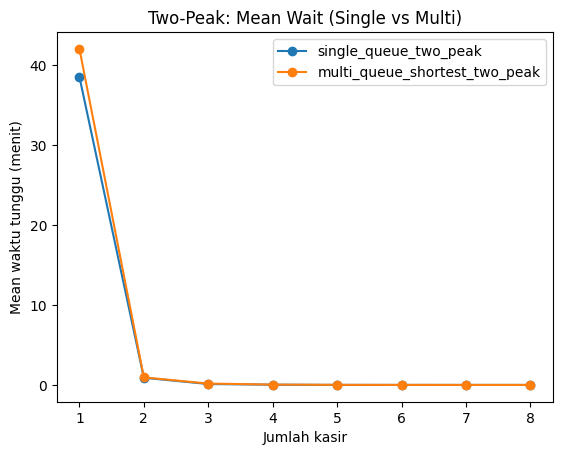

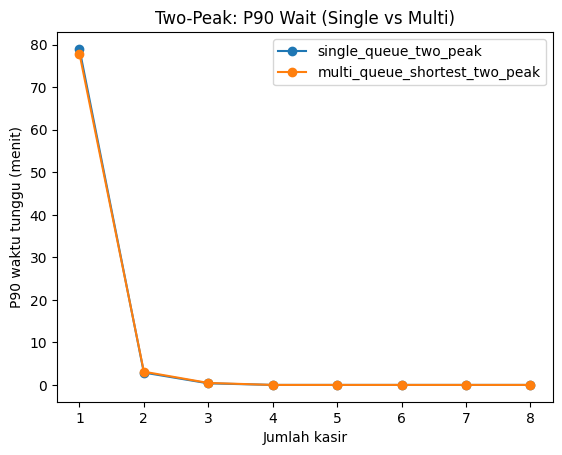

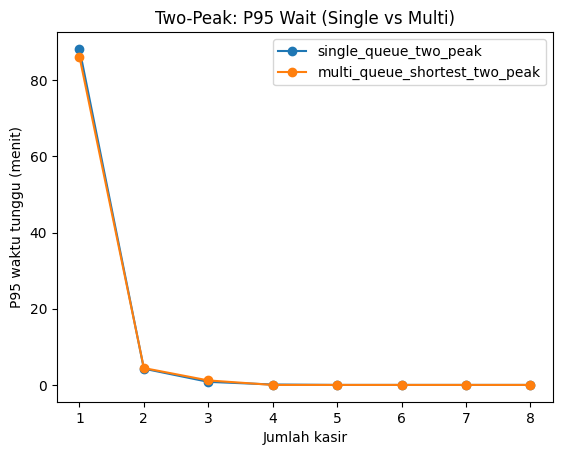

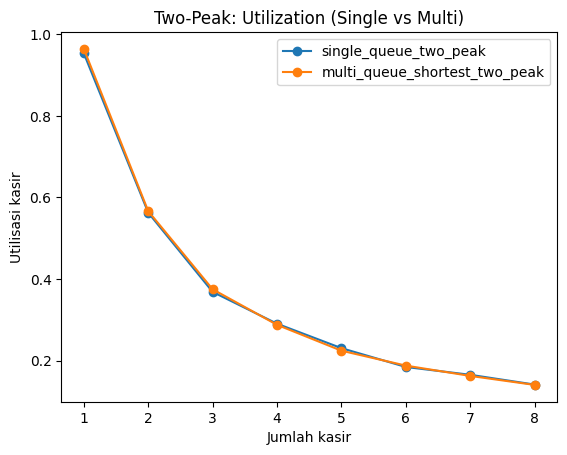

In [17]:
plot_compare(twopeak_compare, "mean_wait", "Mean waktu tunggu (menit)", "Two-Peak: Mean Wait (Single vs Multi)")
plot_compare(twopeak_compare, "wait_p90", "P90 waktu tunggu (menit)", "Two-Peak: P90 Wait (Single vs Multi)")
plot_compare(twopeak_compare, "wait_p95", "P95 waktu tunggu (menit)", "Two-Peak: P95 Wait (Single vs Multi)")
plot_compare(twopeak_compare, "utilization", "Utilisasi kasir", "Two-Peak: Utilization (Single vs Multi)")

## 8) Kasir heterogen: 1 kasir cepat + lainnya normal

Realistis: kasir senior sering lebih cepat.
Kita skalakan service time per kasir:
- kasir cepat: factor 0.85
- kasir normal: factor 1.00

Kita terapkan pada multi-queue dan lihat dampaknya ke mean & P95.

In [18]:
def simulate_multi_queue_detail_hetero(
    cashiers_n: int,
    p: ModelParams,
    seed: int,
    speed_factors: List[float] = None
) -> RunDetail:
    rng = np.random.default_rng(seed)
    env = simpy.Environment()
    cashiers = [simpy.Resource(env, capacity=1) for _ in range(cashiers_n)]

    if speed_factors is None:
        speed_factors = [1.0] * cashiers_n
    assert len(speed_factors) == cashiers_n

    waits: List[float] = []
    systems: List[float] = []
    monitor = QueueMonitor(p.warmup_minutes)
    busy_time = 0.0

    def approx_line_length(r: simpy.Resource) -> int:
        return len(r.queue) + (1 if r.count > 0 else 0)

    def total_waiting() -> int:
        return sum(len(r.queue) for r in cashiers)

    def customer(cid: int):
        nonlocal busy_time
        t_arr = env.now
        monitor.update(env.now, total_waiting())

        lengths = [approx_line_length(r) for r in cashiers]
        min_len = min(lengths)
        candidates = [i for i, L in enumerate(lengths) if L == min_len]
        idx = int(rng.choice(candidates))
        chosen = cashiers[idx]

        with chosen.request() as req:
            yield req
            t_start = env.now
            monitor.update(env.now, total_waiting())

            st = sample_service_time_min(p, rng) * speed_factors[idx]

            if t_arr >= p.warmup_minutes:
                waits.append(t_start - t_arr)
            if t_start >= p.warmup_minutes:
                busy_time += st

            yield env.timeout(st)

            t_dep = env.now
            if t_arr >= p.warmup_minutes:
                systems.append(t_dep - t_arr)

            monitor.update(env.now, total_waiting())

    def arrivals():
        cid = 0
        while env.now < p.sim_minutes:
            lam = arrival_rate(env.now, p)
            inter = rng.exponential(1.0 / lam) if lam > 0 else 1e9
            yield env.timeout(inter)
            cid += 1
            env.process(customer(cid))
            monitor.update(env.now, total_waiting())

    env.process(arrivals())
    env.run(until=p.sim_minutes)

    obs = max(p.sim_minutes - p.warmup_minutes, 1e-9)
    util = busy_time / (cashiers_n * obs)

    return RunDetail(
        model="multi_queue_hetero",
        cashiers=cashiers_n,
        waits=np.array(waits, dtype=float),
        systems=np.array(systems, dtype=float),
        avg_queue_len=float(monitor.average(p.sim_minutes)),
        max_queue_len=int(monitor.max_q),
        utilization=float(util),
    )

In [19]:
def run_hetero_summary(c: int, p: ModelParams, n_rep=30, seed0=52000):
    speed = [0.85] + [1.0]*(c-1)  # kasir 1 cepat
    runs = []
    for i in range(n_rep):
        runs.append(simulate_multi_queue_detail_hetero(c, p, seed=seed0 + 100*c + i, speed_factors=speed))
    s = summarize_detail(runs)
    s["model"] = "multi_queue_hetero_fast1"
    s["cashiers"] = c
    return s

rows = []
for c in [2, 3, 4]:
    base_runs = run_replications_detail(simulate_multi_queue_detail, c, params, NREP, seed0=42000 + 100*c)
    base_sum = summarize_detail(base_runs)
    base_sum["model"] = "multi_queue_shortest"
    base_sum["cashiers"] = c
    rows.append(base_sum)

    rows.append(run_hetero_summary(c, params, n_rep=NREP, seed0=52000))

hetero_df = pd.DataFrame(rows).sort_values(["cashiers","model"])
hetero_df[["model","cashiers","mean_wait","wait_p90","wait_p95","utilization","avg_queue_len","n_customers"]]

,model,cashiers,mean_wait,wait_p90,wait_p95,utilization,avg_queue_len,n_customers
1,multi_queue_hetero_fast1,2,0.582772,2.052297,3.159443,0.464381,0.354601,10261
0,multi_queue_shortest,2,0.865836,3.039476,4.559348,0.489998,0.546000,10141
3,multi_queue_hetero_fast1,3,0.107790,0.070893,0.776400,0.320158,0.061497,10319
2,multi_queue_shortest,3,0.155938,0.324824,1.028569,0.331990,0.091604,10156
5,multi_queue_hetero_fast1,4,0.034967,0.000000,0.000000,0.241869,0.021032,10196
4,multi_queue_shortest,4,0.034681,0.000000,0.000000,0.247417,0.020828,10222


# Narasi Laporan 

## Baseline (1 peak)
- Bandingkan single queue vs multi-queue pada jumlah kasir 1–4.
- Laporkan mean wait dan P90/P95 untuk menunjukkan ekor panjang.

## SLA
- Gunakan SLA: mean wait ≤ 3 menit dan P90 ≤ 5 menit.
- Laporkan jumlah kasir minimum untuk single vs multi.

## Two-peak
- Terapkan dua jam sibuk (siang & sore).
- Ulangi analisis SLA dan tunjukkan apakah sistem butuh kasir lebih banyak dibanding baseline.

## Kasir heterogen (opsional)
- Uji skenario 1 kasir cepat.
- Diskusikan dampak pada mean wait dan terutama P95 (pengalaman pelanggan terburuk).

## Kesimpulan
- Rekomendasikan jumlah kasir dan kebijakan antrean (single/multi) berdasarkan SLA + trade-off utilisasi.